# Porto Seguro’s Safe Driver Prediction

I got Felipe Antunes code as a startpack: https://github.com/felipeeeantunes/udacity_live

## Initializing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import gc
from time import time
from multiprocessing import *

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [ ]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [ ]:
# Setting working directory
path = '../data/raw/'

## Loading Files

In [ ]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [ ]:
y = train['target']
del train['target']

In [ ]:
y.head(5)

In [ ]:
id_train = train['id'].values
id_test = test['id'].values

In [ ]:
columns_original = list(train.columns)
columns_original

In [ ]:
train.head(5)

### Transforming -1 'null's in np.NaN

In [ ]:
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

## Target Analysis

In [ ]:
plt.figure(figsize=(5,5))

ax = sns.countplot(x=y, color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(y)), (p.get_x()+ 0.3, p.get_height()+10000))

## Data Analysis

In [ ]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        source = 'id'
        if '_ind_' in col:
            source = 'ind'
        if '_reg_' in col:
            source = 'reg'
        elif '_car_' in col:
            source = 'car'
        elif '_calc_' in col:
            source = 'calc'
        
        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype,
            'source' : source
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype', 'source'])
    meta.set_index('varname', inplace=True)
    return meta
        

In [ ]:
meta_data = get_meta(train)
meta_data

In [ ]:
meta_counts = meta_data.groupby(['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],x="level",y="dtype",ax=ax,color=default_color)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [ ]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

In [ ]:
msno.dendrogram(train[columns_original],figsize=(20,20))

### Missing Values

In [ ]:
missingValueColumns = train.columns[train.isnull().any()].tolist()
df_null = train[missingValueColumns]

In [ ]:
msno.bar(df_null,figsize=(20,8),color=default_color,fontsize=18,labels=True)

### Correlations between missing Values

In [ ]:
msno.heatmap(df_null,figsize=(10,10),cmap=colormap)

In [ ]:
msno.dendrogram(df_null,figsize=(10,8))

In [ ]:
sorted_data = msno.nullity_sort(df_null, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

### Continuous Features Analysis

In [ ]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Use -1 instead of NaN

In [ ]:
train = train.fillna(-1)
test = test.fillna(-1)

### Simple Baseline RF Model and Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
conf_rf_featimp = {
    'n_estimators': 200,
    'max_depth': 6,
    'min_samples_leaf': 10,
    'max_features': 0.2,
    'n_jobs': -1,
    'random_state': 0
}

In [ ]:
rf_featimp = RandomForestClassifier(**conf_rf_featimp)

In [ ]:
t0 = time()
rf_featimp.fit(train, y)
print("----- Training Time: %  secs. -----" % (time()-t0))

In [ ]:
features = columns_original

In [ ]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [ ]:
feature_importance = get_feature_importance_df(rf_featimp.feature_importances_, features)

In [463]:
feature_importance

,feature,importance
0,ps_car_13,0.15
1,ps_ind_05_cat,0.11
2,ps_ind_17_bin,0.10
3,ps_reg_03,0.08
4,ps_car_07_cat,0.05
5,ps_car_04_cat,0.04
6,ps_ind_03,0.04
7,ps_reg_02,0.04
8,ps_ind_07_bin,0.04
9,ps_ind_06_bin,0.03


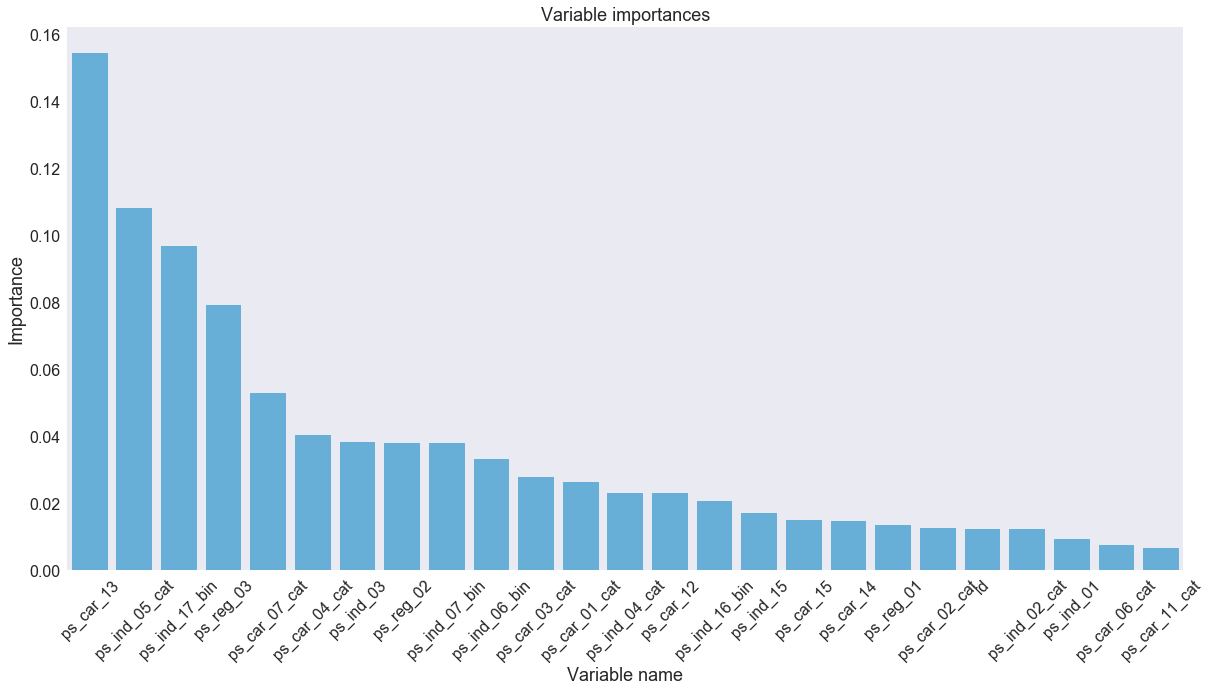

In [464]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
g=sns.barplot(data=feature_importance,x="feature",y="importance",ax=ax,color=default_color,)
for item in g.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances")

## Cross Val function and Other Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
def cross_val_model(X, y, model, n_splits=3):
   
    X = np.array(X)
    y = np.array(y)

    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y))

    cross_score_mean = 0.0

    t0 = time()
    
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f (%.5f)" % (cross_score.mean(), cross_score.mean()*2-1)) 
        print("    [%10d secs elapsed]: cross_score: %.5f (%.5f)" % (time()-t0, cross_score.mean(), cross_score.mean()*2-1)) 
        cross_score_mean += cross_score.mean()
        
    cross_score_mean /= n_splits
    print("cross_score_mean: %.5f (%.5f)" % (cross_score_mean, cross_score_mean*2-1))

#### Cross Val - Random Forest

In [ ]:
conf_rf_model = {
    'n_estimators': 200,
    'max_depth': 6,
    'min_samples_split': 70,
    'min_samples_leaf': 30,
    'n_jobs': -1,
}

In [ ]:
rf_model = RandomForestClassifier(**conf_rf_model)

In [ ]:
cross_val_model(train, y, rf_model)

#### Cross Val - XGBoost

In [ ]:
# parameters from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
conf_xgb_model = {
    'n_estimators': 200,
    'max_depth': 4,
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'nthread': 2,
    'min_child_weight': 100
}

In [ ]:
xgb_model = XGBClassifier(**conf_xgb_model)

In [ ]:
cross_val_model(train, y, xgb_model)

#### Cross Val - LGBM

In [ ]:
conf_lgb_model = {
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'max_depth': 4,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'sub_feature': 0.8,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,
}

In [ ]:
lgb_model = LGBMClassifier(**conf_lgb_model)

In [ ]:
cross_val_model(train, y, lgb_model)

## Feature Engineering & Selection

In [ ]:
# Selected features from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
selected_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
    "ps_reg_03",  #            : 1408.42 / shadow  511.15
    "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
    "ps_ind_03",  #            : 1219.47 / shadow  230.55
    "ps_ind_15",  #            :  922.18 / shadow  242.00
    "ps_reg_02",  #            :  920.65 / shadow  267.50
    "ps_car_14",  #            :  798.48 / shadow  549.58
    "ps_car_12",  #            :  731.93 / shadow  293.62
    "ps_car_01_cat",  #        :  698.07 / shadow  178.72
    "ps_car_07_cat",  #        :  694.53 / shadow   36.35
    "ps_ind_17_bin",  #        :  620.77 / shadow   23.15
    "ps_car_03_cat",  #        :  611.73 / shadow   50.67
    "ps_reg_01",  #            :  598.60 / shadow  178.57
    "ps_car_15",  #            :  593.35 / shadow  226.43
    "ps_ind_01",  #            :  547.32 / shadow  154.58
    "ps_ind_16_bin",  #        :  475.37 / shadow   34.17
    "ps_ind_07_bin",  #        :  435.28 / shadow   28.92
    "ps_car_06_cat",  #        :  398.02 / shadow  212.43
    "ps_car_04_cat",  #        :  376.87 / shadow   76.98
    "ps_ind_06_bin",  #        :  370.97 / shadow   36.13
    "ps_car_09_cat",  #        :  214.12 / shadow   81.38
    "ps_car_02_cat",  #        :  203.03 / shadow   26.67
    "ps_ind_02_cat",  #        :  189.47 / shadow   65.68
    "ps_car_11",  #            :  173.28 / shadow   76.45
    "ps_car_05_cat",  #        :  172.75 / shadow   62.92
    "ps_calc_09",  #           :  169.13 / shadow  129.72
    "ps_calc_05",  #           :  148.83 / shadow  120.68
    "ps_ind_08_bin",  #        :  140.73 / shadow   27.63
    "ps_car_08_cat",  #        :  120.87 / shadow   28.82
    "ps_ind_09_bin",  #        :  113.92 / shadow   27.05
    "ps_ind_04_cat",  #        :  107.27 / shadow   37.43
    "ps_ind_18_bin",  #        :   77.42 / shadow   25.97
    "ps_ind_12_bin",  #        :   39.67 / shadow   15.52
    "ps_ind_14",  #            :   37.37 / shadow   16.65
    "ps_car_11_cat" # Very nice spot from Tilii : https://www.kaggle.com/tilii7
]

In [ ]:
cross_val_model(train[selected_features], y, rf_model)

In [ ]:
cross_val_model(train[selected_features], y, xgb_model)

In [ ]:
cross_val_model(train[selected_features], y, lgb_model)

### Adding Combs

In [ ]:
train.head(5)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# add combinations from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]
start = time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f' % (name1, n_c + 1, (time() - start) / 60), end='')
    print('\r' * 75, end='')
    train[name1] = train[f1].apply(lambda x: str(x)) + "_" + train[f2].apply(lambda x: str(x))
    test[name1] = test[f1].apply(lambda x: str(x)) + "_" + test[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train[name1].values) + list(test[name1].values))
    train[name1] = lbl.transform(list(train[name1].values))
    test[name1] = lbl.transform(list(test[name1].values))

In [ ]:
new_features = [f1 + '_plus_' + f2 for (f1, f2) in combs]
selected_features.extend(new_features)
new_features

In [ ]:
train.head(5)

In [ ]:
selected_features

In [ ]:
cross_val_model(train[selected_features], y, rf_model)

In [ ]:
cross_val_model(train[selected_features], y, xgb_model)

In [ ]:
cross_val_model(train[selected_features], y, lgb_model)

### Reconstructing ps_reg_03

In [ ]:
### from Pascal's (https://www.kaggle.com/pnagel/reconstruction-of-ps-reg-03)
def recon(reg):
    integer = int(np.round((40*reg)**2)) 
    for a in range(32):
        if (integer - a) % 31 == 0:
            A = a
    M = (integer - A)//31
    return A, M

train['ps_reg_A'] = train['ps_reg_03'].apply(lambda x: recon(x)[0] )
train['ps_reg_M'] = train['ps_reg_03'].apply(lambda x: recon(x)[1])
train['ps_reg_A'].replace(19, -1, inplace=True) # replace -1 with np.NaN
train['ps_reg_M'].replace(51, -1, inplace=True) # replace -1 with np.NaN

test['ps_reg_A'] = test['ps_reg_03'].apply(lambda x: recon(x)[0])
test['ps_reg_M'] = test['ps_reg_03'].apply(lambda x: recon(x)[1])
test['ps_reg_A'].replace(19, np.NaN, inplace=True) # replace -1 with np.NaN
test['ps_reg_M'].replace(51, np.NaN, inplace=True) # replace -1 with np.NaN

In [ ]:
new_features = ['ps_reg_A', 'ps_reg_M']
selected_features.extend(new_features)
selected_features.remove('ps_reg_03')

In [ ]:
selected_features

In [ ]:
cross_val_model(train[selected_features], y, rf_model)

In [ ]:
cross_val_model(train[selected_features], y, xgb_model)

In [ ]:
cross_val_model(train[selected_features], y, lgb_model)

In [ ]:
for x in ['ps_reg_A', 'ps_reg_M']: selected_features.remove(x)
selected_features.append('ps_reg_03')

In [ ]:
selected_features

### One HOT (<= 3 classes) and Categorical Target Encoding (for >3 classes)

In [ ]:
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

In [394]:
one_hot = {c: len(list(train[c].unique())) for c in selected_features}
sorted( ((v,k) for k,v in one_hot.items()), reverse=True)

[(70482, 'ps_car_13'),
 (5013, 'ps_reg_03'),
 (850, 'ps_car_14'),
 (184, 'ps_car_12'),
 (104, 'ps_car_11_cat'),
 (100, 'ps_reg_01_plus_ps_car_04_cat'),
 (24, 'ps_reg_01_plus_ps_car_02_cat'),
 (19, 'ps_reg_02'),
 (18, 'ps_car_06_cat'),
 (15, 'ps_car_15'),
 (14, 'ps_ind_15'),
 (13, 'ps_car_01_cat'),
 (12, 'ps_ind_03'),
 (10, 'ps_reg_01'),
 (10, 'ps_car_04_cat'),
 (8, 'ps_ind_05_cat'),
 (8, 'ps_ind_01'),
 (8, 'ps_calc_09'),
 (7, 'ps_calc_05'),
 (6, 'ps_car_09_cat'),
 (5, 'ps_ind_14'),
 (5, 'ps_ind_02_cat'),
 (5, 'ps_car_11'),
 (3, 'ps_ind_04_cat'),
 (3, 'ps_car_07_cat'),
 (3, 'ps_car_05_cat'),
 (3, 'ps_car_03_cat'),
 (3, 'ps_car_02_cat'),
 (2, 'ps_ind_18_bin'),
 (2, 'ps_ind_17_bin'),
 (2, 'ps_ind_16_bin'),
 (2, 'ps_ind_12_bin'),
 (2, 'ps_ind_09_bin'),
 (2, 'ps_ind_08_bin'),
 (2, 'ps_ind_07_bin'),
 (2, 'ps_ind_06_bin'),
 (2, 'ps_car_08_cat')]

In [ ]:
train.head(10)

In [409]:
one_hot_lt_than_3_unique = { k:v for k, v in one_hot.items() if v <= 3}
one_hot_me_than_3_unique = { k:v for k, v in one_hot.items() if v > 3}
one_hot_me_than_3_unique_cat = { k:v for k, v in one_hot.items() if v > 3 and 'cat' in k}
one_hot_lt_than_3_unique, one_hot_me_than_3_unique, one_hot_me_than_3_unique_cat

({'ps_car_02_cat': 3,
  'ps_car_03_cat': 3,
  'ps_car_05_cat': 3,
  'ps_car_07_cat': 3,
  'ps_car_08_cat': 2,
  'ps_ind_04_cat': 3,
  'ps_ind_06_bin': 2,
  'ps_ind_07_bin': 2,
  'ps_ind_08_bin': 2,
  'ps_ind_09_bin': 2,
  'ps_ind_12_bin': 2,
  'ps_ind_16_bin': 2,
  'ps_ind_17_bin': 2,
  'ps_ind_18_bin': 2},
 {'ps_calc_05': 7,
  'ps_calc_09': 8,
  'ps_car_01_cat': 13,
  'ps_car_04_cat': 10,
  'ps_car_06_cat': 18,
  'ps_car_09_cat': 6,
  'ps_car_11': 5,
  'ps_car_11_cat': 104,
  'ps_car_12': 184,
  'ps_car_13': 70482,
  'ps_car_14': 850,
  'ps_car_15': 15,
  'ps_ind_01': 8,
  'ps_ind_02_cat': 5,
  'ps_ind_03': 12,
  'ps_ind_05_cat': 8,
  'ps_ind_14': 5,
  'ps_ind_15': 14,
  'ps_reg_01': 10,
  'ps_reg_01_plus_ps_car_02_cat': 24,
  'ps_reg_01_plus_ps_car_04_cat': 100,
  'ps_reg_02': 19,
  'ps_reg_03': 5013},
 {'ps_car_01_cat': 13,
  'ps_car_04_cat': 10,
  'ps_car_06_cat': 18,
  'ps_car_09_cat': 6,
  'ps_car_11_cat': 104,
  'ps_ind_02_cat': 5,
  'ps_ind_05_cat': 8,
  'ps_reg_01_plus_ps_car_

In [400]:
def OHE_by_unique(train, one_hot_lists, limit):
    #ONE-HOT enconde features with more than 2 and less than 'limit' unique values
    df = train.copy()
    for c in one_hot.keys():
        if len(one_hot_lists[c]) > 2 and len(one_hot_lists[c]) <= limit:
            for val in one_hot_lists[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
            print(c)
    return df

In [401]:
one_hot

{'ps_calc_05': 7,
 'ps_calc_09': 8,
 'ps_car_01_cat': 13,
 'ps_car_02_cat': 3,
 'ps_car_03_cat': 3,
 'ps_car_04_cat': 10,
 'ps_car_05_cat': 3,
 'ps_car_06_cat': 18,
 'ps_car_07_cat': 3,
 'ps_car_08_cat': 2,
 'ps_car_09_cat': 6,
 'ps_car_11': 5,
 'ps_car_11_cat': 104,
 'ps_car_12': 184,
 'ps_car_13': 70482,
 'ps_car_14': 850,
 'ps_car_15': 15,
 'ps_ind_01': 8,
 'ps_ind_02_cat': 5,
 'ps_ind_03': 12,
 'ps_ind_04_cat': 3,
 'ps_ind_05_cat': 8,
 'ps_ind_06_bin': 2,
 'ps_ind_07_bin': 2,
 'ps_ind_08_bin': 2,
 'ps_ind_09_bin': 2,
 'ps_ind_12_bin': 2,
 'ps_ind_14': 5,
 'ps_ind_15': 14,
 'ps_ind_16_bin': 2,
 'ps_ind_17_bin': 2,
 'ps_ind_18_bin': 2,
 'ps_reg_01': 10,
 'ps_reg_01_plus_ps_car_02_cat': 24,
 'ps_reg_01_plus_ps_car_04_cat': 100,
 'ps_reg_02': 19,
 'ps_reg_03': 5013}

In [407]:
one_hot_lists = {c: list(train[c].unique()) for c in selected_features}
list(one_hot_lists.items())[:2]

[('ps_ind_15', [11, 3, 12, 8, 9, 6, 13, 4, 10, 5, 7, 2, 0, 1]),
 ('ps_ind_02_cat', [2.0, 1.0, 4.0, 3.0, nan])]

In [405]:
print('train')
oh_train = OHE_by_unique(train, one_hot_lists, 3)
print('test')
oh_test = OHE_by_unique(test, one_hot_lists, 3)

train
ps_car_03_cat
ps_car_07_cat
ps_car_02_cat
ps_ind_04_cat
ps_car_05_cat
test
ps_car_03_cat
ps_car_07_cat
ps_car_02_cat
ps_ind_04_cat
ps_car_05_cat


In [411]:
oh_onehotted_columns = ['ps_car_03_cat','ps_car_07_cat','ps_car_02_cat','ps_ind_04_cat','ps_car_05_cat']
selected_features_oh = selected_features.copy()
selected_features_oh, oh_onehotted_columns

(['ps_car_13',
  'ps_ind_05_cat',
  'ps_ind_03',
  'ps_ind_15',
  'ps_reg_02',
  'ps_car_14',
  'ps_car_12',
  'ps_car_01_cat',
  'ps_car_07_cat',
  'ps_ind_17_bin',
  'ps_car_03_cat',
  'ps_reg_01',
  'ps_car_15',
  'ps_ind_01',
  'ps_ind_16_bin',
  'ps_ind_07_bin',
  'ps_car_06_cat',
  'ps_car_04_cat',
  'ps_ind_06_bin',
  'ps_car_09_cat',
  'ps_car_02_cat',
  'ps_ind_02_cat',
  'ps_car_11',
  'ps_car_05_cat',
  'ps_calc_09',
  'ps_calc_05',
  'ps_ind_08_bin',
  'ps_car_08_cat',
  'ps_ind_09_bin',
  'ps_ind_04_cat',
  'ps_ind_18_bin',
  'ps_ind_12_bin',
  'ps_ind_14',
  'ps_car_11_cat',
  'ps_reg_01_plus_ps_car_02_cat',
  'ps_reg_01_plus_ps_car_04_cat',
  'ps_reg_03'],
 ['ps_car_03_cat',
  'ps_car_07_cat',
  'ps_car_02_cat',
  'ps_ind_04_cat',
  'ps_car_05_cat'])

In [412]:
for c in oh_onehotted_columns:
    if c in selected_features_oh:
        selected_features_oh.remove(c)
oh_columns = [c for c in oh_train.columns if c in selected_features or '_oh_' in c]
print(oh_columns)
selected_features_oh.extend(oh_columns)
print(selected_features_oh)

['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_05', 'ps_calc_09', 'ps_reg_01_plus_ps_car_02_cat', 'ps_reg_01_plus_ps_car_04_cat', 'ps_car_03_cat_oh_nan', 'ps_car_03_cat_oh_0.0', 'ps_car_03_cat_oh_1.0', 'ps_car_07_cat_oh_1.0', 'ps_car_07_cat_oh_nan', 'ps_car_07_cat_oh_0.0', 'ps_car_02_cat_oh_1.0', 'ps_car_02_cat_oh_0.0', 'ps_car_02_cat_oh_nan', 'ps_ind_04_cat_oh_1.0', 'ps_ind_04_cat_oh_0.0', 'ps_ind_04_cat_oh_nan', 'ps_car_05_cat_oh_1.0', 'ps_car_05_cat_oh_nan', 'ps_car_05_cat_oh_0.0']
['ps_car_13', 'ps_ind_05_cat', 'ps

In [413]:
oh_train.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_07_cat_oh_0.0,ps_car_02_cat_oh_1.0,ps_car_02_cat_oh_0.0,ps_car_02_cat_oh_nan,ps_ind_04_cat_oh_1.0,ps_ind_04_cat_oh_0.0,ps_ind_04_cat_oh_nan,ps_car_05_cat_oh_1.0,ps_car_05_cat_oh_nan,ps_car_05_cat_oh_0.0
0,7,2,2.00,5,1.00,0.00,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,9,1,1.00,7,0.00,0.00,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,13,5,4.00,9,1.00,0.00,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,16,0,1.00,2,0.00,0.00,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,17,0,2.00,0,1.00,0.00,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [414]:
oh_train = oh_train.fillna(-1)
oh_test = oh_test.fillna(-1)

In [ ]:
cross_val_model(train[selected_features], y, rf_model)

In [ ]:
cross_val_model(train[selected_features], y, xgb_model)

In [358]:
cross_val_model(train[selected_features], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.63201 (0.26402)
    [        21 secs elapsed]: cross_score: 0.63201 (0.26402)
Fit LGBMClassifier fold 2
    cross_score: 0.63193 (0.26387)
    [        40 secs elapsed]: cross_score: 0.63193 (0.26387)
Fit LGBMClassifier fold 3
    cross_score: 0.63699 (0.27397)
    [        58 secs elapsed]: cross_score: 0.63699 (0.27397)
cross_score_mean: 0.63364 (0.26729)


In [ ]:
cross_val_model(oh_train[selected_features_oh], y, rf_model)

In [ ]:
cross_val_model(oh_train[selected_features_oh], y, xgb_model)

In [415]:
cross_val_model(oh_train[selected_features_oh], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.63279 (0.26559)
    [        31 secs elapsed]: cross_score: 0.63279 (0.26559)
Fit LGBMClassifier fold 2
    cross_score: 0.63195 (0.26390)
    [        58 secs elapsed]: cross_score: 0.63195 (0.26390)
Fit LGBMClassifier fold 3
    cross_score: 0.63681 (0.27362)
    [        85 secs elapsed]: cross_score: 0.63681 (0.27362)
cross_score_mean: 0.63385 (0.26770)


#### Target Encoding Only Categorical variables

In [416]:
one_hot_lt_than_3_unique, one_hot_me_than_3_unique, one_hot_me_than_3_unique_cat

({'ps_car_02_cat': 3,
  'ps_car_03_cat': 3,
  'ps_car_05_cat': 3,
  'ps_car_07_cat': 3,
  'ps_car_08_cat': 2,
  'ps_ind_04_cat': 3,
  'ps_ind_06_bin': 2,
  'ps_ind_07_bin': 2,
  'ps_ind_08_bin': 2,
  'ps_ind_09_bin': 2,
  'ps_ind_12_bin': 2,
  'ps_ind_16_bin': 2,
  'ps_ind_17_bin': 2,
  'ps_ind_18_bin': 2},
 {'ps_calc_05': 7,
  'ps_calc_09': 8,
  'ps_car_01_cat': 13,
  'ps_car_04_cat': 10,
  'ps_car_06_cat': 18,
  'ps_car_09_cat': 6,
  'ps_car_11': 5,
  'ps_car_11_cat': 104,
  'ps_car_12': 184,
  'ps_car_13': 70482,
  'ps_car_14': 850,
  'ps_car_15': 15,
  'ps_ind_01': 8,
  'ps_ind_02_cat': 5,
  'ps_ind_03': 12,
  'ps_ind_05_cat': 8,
  'ps_ind_14': 5,
  'ps_ind_15': 14,
  'ps_reg_01': 10,
  'ps_reg_01_plus_ps_car_02_cat': 24,
  'ps_reg_01_plus_ps_car_04_cat': 100,
  'ps_reg_02': 19,
  'ps_reg_03': 5013},
 {'ps_car_01_cat': 13,
  'ps_car_04_cat': 10,
  'ps_car_06_cat': 18,
  'ps_car_09_cat': 6,
  'ps_car_11_cat': 104,
  'ps_ind_02_cat': 5,
  'ps_ind_05_cat': 8,
  'ps_reg_01_plus_ps_car_

In [364]:
# from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [365]:
# adapted from https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283/code
def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [366]:
f_cats = one_hot_me_than_3_unique_cat

In [420]:
te_train = oh_train.copy()
te_test = oh_test.copy()

In [ ]:
te_train = te_train.replace(-1, np.NaN)
te_test = te_test.replace(-1, np.NaN)
#te_train = te_train.fillna(-1)
#te_test = te_test.fillna(-1)

In [421]:
for f in f_cats:
    te_train[f + "_avg"], te_test[f + "_avg"] = target_encode(trn_series=te_train[f],
                                         tst_series=te_test[f],
                                         target=y,
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0)

In [425]:
## Verify transformations

In [422]:
train.head(3)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_reg_01_plus_ps_car_02_cat,ps_reg_01_plus_ps_car_04_cat,ps_reg_A,ps_reg_M
0,7,2,2.00,5,1.00,0.00,0,1,0,0,...,0,1,1,0,0,1,19,70,nan,26.00
1,9,1,1.00,7,0.00,0.00,0,0,1,0,...,0,1,1,0,1,0,21,80,9.00,30.00
2,13,5,4.00,9,1.00,0.00,0,0,1,0,...,0,1,1,0,1,0,1,0,nan,nan


In [424]:
oh_train.head(3)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_07_cat_oh_0.0,ps_car_02_cat_oh_1.0,ps_car_02_cat_oh_0.0,ps_car_02_cat_oh_nan,ps_ind_04_cat_oh_1.0,ps_ind_04_cat_oh_0.0,ps_ind_04_cat_oh_nan,ps_car_05_cat_oh_1.0,ps_car_05_cat_oh_nan,ps_car_05_cat_oh_0.0
0,7,2,2.00,5,1.00,0.00,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,9,1,1.00,7,0.00,0.00,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,13,5,4.00,9,1.00,0.00,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


In [423]:
te_train.head(3)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_reg_01_plus_ps_car_04_cat_avg,ps_ind_05_cat_avg,ps_car_04_cat_avg,ps_car_06_cat_avg,ps_car_02_cat_avg,ps_car_01_cat_avg,ps_ind_04_cat_avg,ps_car_09_cat_avg,ps_car_11_cat_avg,ps_car_05_cat_avg
0,7,2,2.00,5,1.00,0.00,0,1,0,0,...,0.04,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.04,0.04
1,9,1,1.00,7,0.00,0.00,0,0,1,0,...,0.04,0.03,0.03,0.03,0.03,0.04,0.03,0.04,0.02,0.03
2,13,5,4.00,9,1.00,0.00,0,0,1,0,...,0.04,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.03


In [430]:
new_te_columns = [c for c in te_train.columns if '_avg' in c]
new_te_columns

['ps_ind_02_cat_avg',
 'ps_car_03_cat_avg',
 'ps_car_07_cat_avg',
 'ps_reg_01_plus_ps_car_02_cat_avg',
 'ps_reg_01_plus_ps_car_04_cat_avg',
 'ps_ind_05_cat_avg',
 'ps_car_04_cat_avg',
 'ps_car_06_cat_avg',
 'ps_car_02_cat_avg',
 'ps_car_01_cat_avg',
 'ps_ind_04_cat_avg',
 'ps_car_09_cat_avg',
 'ps_car_11_cat_avg',
 'ps_car_05_cat_avg']

In [432]:
selected_features_te = selected_features_oh.copy()
selected_features_te.extend(new_te_columns)
for x in new_te_columns: selected_features_te.remove(x[:-4])
selected_features_te

['ps_car_13',
 'ps_ind_03',
 'ps_ind_15',
 'ps_reg_02',
 'ps_car_14',
 'ps_car_12',
 'ps_ind_17_bin',
 'ps_reg_01',
 'ps_car_15',
 'ps_ind_01',
 'ps_ind_16_bin',
 'ps_ind_07_bin',
 'ps_ind_06_bin',
 'ps_car_11',
 'ps_calc_09',
 'ps_calc_05',
 'ps_ind_08_bin',
 'ps_car_08_cat',
 'ps_ind_09_bin',
 'ps_ind_18_bin',
 'ps_ind_12_bin',
 'ps_ind_14',
 'ps_reg_03',
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_12_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_11_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_05',
 'ps_calc_09',
 'ps_reg_01_plus_ps_car_02_cat',
 'ps_reg_01_plus_ps_car_04_cat',
 'ps_car_03_cat_oh_nan',
 'ps_car_03_cat_oh_0.0',
 'ps_car_03_cat_oh_1.0',
 'ps_car_07_c

In [ ]:
cross_val_model(te_train[selected_features_te], y, rf_model)

In [ ]:
cross_val_model(te_train[selected_features_te], y, xgb_model)

In [433]:
cross_val_model(te_train[selected_features_te], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.63456 (0.26912)
    [        26 secs elapsed]: cross_score: 0.63456 (0.26912)
Fit LGBMClassifier fold 2
    cross_score: 0.63306 (0.26612)
    [        53 secs elapsed]: cross_score: 0.63306 (0.26612)
Fit LGBMClassifier fold 3
    cross_score: 0.63760 (0.27520)
    [        81 secs elapsed]: cross_score: 0.63760 (0.27520)
cross_score_mean: 0.63507 (0.27014)


## Target Encoding a lot of things

In [434]:
f_cats = one_hot_me_than_3_unique

In [435]:
te2_train = oh_train.copy()
te2_test = oh_test.copy()

In [436]:
te2_train = te2_train.replace(-1, np.NaN)
te2_test = te2_test.replace(-1, np.NaN)
#te_train = te_train.fillna(-1)
#te_test = te_test.fillna(-1)

In [437]:
for f in f_cats:
    te2_train[f + "_avg"], te2_test[f + "_avg"] = target_encode(trn_series=te2_train[f],
                                         tst_series=te2_test[f],
                                         target=y,
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0)

In [440]:
new_te2_columns = [c for c in te2_train.columns if '_avg' in c]
new_te2_columns

['ps_ind_15_avg',
 'ps_car_14_avg',
 'ps_car_09_cat_avg',
 'ps_reg_01_plus_ps_car_04_cat_avg',
 'ps_ind_05_cat_avg',
 'ps_ind_14_avg',
 'ps_car_06_cat_avg',
 'ps_car_01_cat_avg',
 'ps_car_11_avg',
 'ps_reg_02_avg',
 'ps_calc_05_avg',
 'ps_ind_03_avg',
 'ps_ind_02_cat_avg',
 'ps_reg_01_avg',
 'ps_reg_03_avg',
 'ps_reg_01_plus_ps_car_02_cat_avg',
 'ps_car_12_avg',
 'ps_car_04_cat_avg',
 'ps_ind_01_avg',
 'ps_car_15_avg',
 'ps_car_11_cat_avg',
 'ps_calc_09_avg',
 'ps_car_13_avg']

In [441]:
selected_features_te2 = selected_features_oh.copy()
selected_features_te2.extend(new_te2_columns)
for x in new_te2_columns: selected_features_te2.remove(x[:-4])
selected_features_te2

['ps_ind_17_bin',
 'ps_ind_16_bin',
 'ps_ind_07_bin',
 'ps_ind_06_bin',
 'ps_ind_08_bin',
 'ps_car_08_cat',
 'ps_ind_09_bin',
 'ps_ind_18_bin',
 'ps_ind_12_bin',
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_12_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_11_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_05',
 'ps_calc_09',
 'ps_reg_01_plus_ps_car_02_cat',
 'ps_reg_01_plus_ps_car_04_cat',
 'ps_car_03_cat_oh_nan',
 'ps_car_03_cat_oh_0.0',
 'ps_car_03_cat_oh_1.0',
 'ps_car_07_cat_oh_1.0',
 'ps_car_07_cat_oh_nan',
 'ps_car_07_cat_oh_0.0',
 'ps_car_02_cat_oh_1.0',
 'ps_car_02_cat_oh_0.

In [ ]:
te2_train = te2_train.fillna(-1)
te2_test = te2_test.fillna(-1)

In [444]:
cross_val_model(te2_train[selected_features_te2], y, rf_model)

Fit RandomForestClassifier fold 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [462]:
cross_val_model(te2_train[selected_features_te2], y, xgb_model)

Fit XGBClassifier fold 1
    cross_score: 0.65569 (0.31139)
    [       166 secs elapsed]: cross_score: 0.65569 (0.31139)
Fit XGBClassifier fold 2
    cross_score: 0.65722 (0.31444)
    [       353 secs elapsed]: cross_score: 0.65722 (0.31444)
Fit XGBClassifier fold 3
    cross_score: 0.66354 (0.32709)
    [       536 secs elapsed]: cross_score: 0.66354 (0.32709)
cross_score_mean: 0.65882 (0.31764)


In [461]:
cross_val_model(te2_train[selected_features_te2], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.84796 (0.69593)
    [        32 secs elapsed]: cross_score: 0.84796 (0.69593)
Fit LGBMClassifier fold 2
    cross_score: 0.84991 (0.69982)
    [        63 secs elapsed]: cross_score: 0.84991 (0.69982)
Fit LGBMClassifier fold 3
    cross_score: 0.85076 (0.70152)
    [        94 secs elapsed]: cross_score: 0.85076 (0.70152)
cross_score_mean: 0.84955 (0.69909)


# Making a submission

In [454]:
selected_features_te2 = list(list(set(selected_features_te2)))

In [455]:
xgb_model.fit(te2_train[selected_features_te2], y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=4,
       min_child_weight=100, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=6e-05, reg_lambda=7e-06,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [456]:
y_pred_xgb = xgb_model.predict_proba(te2_test[selected_features_te2])[:,1]

In [457]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred_xgb
sub.to_csv('xgb_feateng01.csv', index=False)

In [458]:
lgb_model.fit(te2_train[selected_features_te2], y)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=3, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.8, learning_rate=0.05,
        max_bin=255, max_depth=5, metric='binary_logloss',
        min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=20, objective='binary',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        sub_feature=0.8, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [459]:
y_pred = lgb_model.predict_proba(te2_test[selected_features_te2])[:,1]

In [460]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('lgb_feateng01.csv', index=False)

In [465]:
selected_features_te2

['ps_ind_04_cat_oh_0.0',
 'ps_car_12_avg',
 'ps_reg_01_avg',
 'ps_ind_08_bin',
 'ps_ind_17_bin',
 'ps_reg_01_plus_ps_car_04_cat',
 'ps_car_03_cat_oh_0.0',
 'ps_car_01_cat_avg',
 'ps_ind_16_bin',
 'ps_car_05_cat_oh_0.0',
 'ps_ind_14_avg',
 'ps_car_03_cat_oh_nan',
 'ps_car_08_cat',
 'ps_reg_02_avg',
 'ps_car_11',
 'ps_reg_02',
 'ps_car_03_cat_oh_1.0',
 'ps_car_11_cat_avg',
 'ps_ind_12_bin',
 'ps_reg_01_plus_ps_car_02_cat_avg',
 'ps_reg_01_plus_ps_car_04_cat_avg',
 'ps_car_11_avg',
 'ps_car_02_cat_oh_nan',
 'ps_ind_01',
 'ps_car_02_cat_oh_1.0',
 'ps_ind_03_avg',
 'ps_ind_01_avg',
 'ps_car_07_cat_oh_1.0',
 'ps_ind_05_cat_avg',
 'ps_calc_05_avg',
 'ps_car_11_cat',
 'ps_calc_09',
 'ps_car_05_cat',
 'ps_car_13',
 'ps_ind_15',
 'ps_car_14',
 'ps_car_03_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_ind_09_bin',
 'ps_car_07_cat_oh_nan',
 'ps_car_07_cat_oh_0.0',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_14',
 'ps_calc_09_avg',
 'ps_ind_18_bin',
 'ps_car_05_cat_oh_1.0',
 'ps_car_06_cat',
 'ps_

In [482]:
selected_features_te3 = selected_features_te2.copy()

In [474]:
for c in ['ps_car_13_avg']:
    if c in selected_features_te3:
        selected_features_te3.remove(c)
        selected_features_te3.append(c[:-4])

In [477]:
cross_val_model(te2_train[selected_features_te3], y, xgb_model)

Fit XGBClassifier fold 1
    cross_score: 0.64143 (0.28286)
    [       166 secs elapsed]: cross_score: 0.64143 (0.28286)
Fit XGBClassifier fold 2
    cross_score: 0.64622 (0.29243)
    [       345 secs elapsed]: cross_score: 0.64622 (0.29243)
Fit XGBClassifier fold 3
    cross_score: 0.64926 (0.29852)
    [       518 secs elapsed]: cross_score: 0.64926 (0.29852)
cross_score_mean: 0.64564 (0.29127)


In [476]:
cross_val_model(te2_train[selected_features_te3], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.66807 (0.33614)
    [        28 secs elapsed]: cross_score: 0.66807 (0.33614)
Fit LGBMClassifier fold 2
    cross_score: 0.67196 (0.34392)
    [        63 secs elapsed]: cross_score: 0.67196 (0.34392)
Fit LGBMClassifier fold 3
    cross_score: 0.67146 (0.34292)
    [        93 secs elapsed]: cross_score: 0.67146 (0.34292)
cross_score_mean: 0.67050 (0.34099)


In [483]:
selected_features_te3 = selected_features_te2.copy()
for c in ['ps_car_13_avg', 'ps_car_14_avg', 'ps_car_12_avg' ]:
    if c in selected_features_te3:
        selected_features_te3.remove(c)
        selected_features_te3.append(c[:-4])

In [490]:
selected_features_te3 = list(set(selected_features_te3))

In [493]:
cross_val_model(te2_train[selected_features_te3], y, xgb_model)

Fit XGBClassifier fold 1
    cross_score: 0.64254 (0.28508)
    [       178 secs elapsed]: cross_score: 0.64254 (0.28508)
Fit XGBClassifier fold 2
    cross_score: 0.64588 (0.29177)
    [       342 secs elapsed]: cross_score: 0.64588 (0.29177)
Fit XGBClassifier fold 3
    cross_score: 0.64915 (0.29829)
    [       506 secs elapsed]: cross_score: 0.64915 (0.29829)
cross_score_mean: 0.64586 (0.29171)


In [492]:
cross_val_model(te2_train[selected_features_te3], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.66720 (0.33441)
    [        37 secs elapsed]: cross_score: 0.66720 (0.33441)
Fit LGBMClassifier fold 2
    cross_score: 0.67138 (0.34276)
    [        67 secs elapsed]: cross_score: 0.67138 (0.34276)
Fit LGBMClassifier fold 3
    cross_score: 0.67029 (0.34058)
    [        96 secs elapsed]: cross_score: 0.67029 (0.34058)
cross_score_mean: 0.66962 (0.33925)


In [491]:
lgb_model.fit(te2_train[selected_features_te3], y)
y_pred = lgb_model.predict_proba(te2_test[selected_features_te3])[:,1]
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('lgb_feateng02.csv', index=False)

In [489]:
xgb_model.fit(te2_train[selected_features_te3], y)
y_pred = xgb_model.predict_proba(te2_test[selected_features_te3])[:,1]
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('xgb_feateng02.csv', index=False)

In [496]:
te2_train = te2_train.fillna(-1)
te2_test = te2_test.fillna(-1)

In [506]:
selected_features_te3b = selected_features_te3.copy()
selected_features_te3b.remove('ps_car_03_cat')

In [507]:
t0 = time()
rf_model.fit(te2_train[selected_features_te3b], y)
print("----- Training Time: %  secs. -----" % (time()-t0))

----- Training Time: 94.31579995155334ecs. -----


In [508]:
features = selected_features_te3b
features

['ps_ind_04_cat_oh_0.0',
 'ps_reg_01_avg',
 'ps_ind_08_bin',
 'ps_ind_17_bin',
 'ps_reg_01_plus_ps_car_04_cat',
 'ps_car_03_cat_oh_0.0',
 'ps_car_01_cat_avg',
 'ps_ind_16_bin',
 'ps_car_05_cat_oh_0.0',
 'ps_ind_14_avg',
 'ps_car_03_cat_oh_nan',
 'ps_car_08_cat',
 'ps_reg_02_avg',
 'ps_car_11',
 'ps_reg_02',
 'ps_car_03_cat_oh_1.0',
 'ps_car_11_cat_avg',
 'ps_ind_12_bin',
 'ps_reg_01_plus_ps_car_02_cat_avg',
 'ps_reg_01_plus_ps_car_04_cat_avg',
 'ps_car_11_avg',
 'ps_car_02_cat_oh_nan',
 'ps_ind_01',
 'ps_car_02_cat_oh_1.0',
 'ps_ind_03_avg',
 'ps_ind_01_avg',
 'ps_car_07_cat_oh_1.0',
 'ps_ind_05_cat_avg',
 'ps_calc_05_avg',
 'ps_car_11_cat',
 'ps_calc_09',
 'ps_car_05_cat',
 'ps_car_13',
 'ps_ind_15',
 'ps_car_14',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_ind_09_bin',
 'ps_car_07_cat_oh_nan',
 'ps_car_07_cat_oh_0.0',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_14',
 'ps_calc_09_avg',
 'ps_ind_18_bin',
 'ps_car_05_cat_oh_1.0',
 'ps_car_06_cat',
 'ps_car_06_cat_avg',
 'ps_car_01_cat',
 

In [509]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [510]:
feature_importance = get_feature_importance_df(rf_featimp.feature_importances_, features)

In [511]:
feature_importance

,feature,importance
0,ps_car_07_cat,0.15
1,ps_car_03_cat_oh_0.0,0.11
2,ps_ind_12_bin,0.10
3,ps_car_02_cat_oh_nan,0.08
4,ps_calc_05_avg,0.05
5,ps_ind_01_avg,0.04
6,ps_ind_17_bin,0.04
7,ps_car_11_avg,0.04
8,ps_ind_16_bin,0.04
9,ps_car_01_cat_avg,0.03


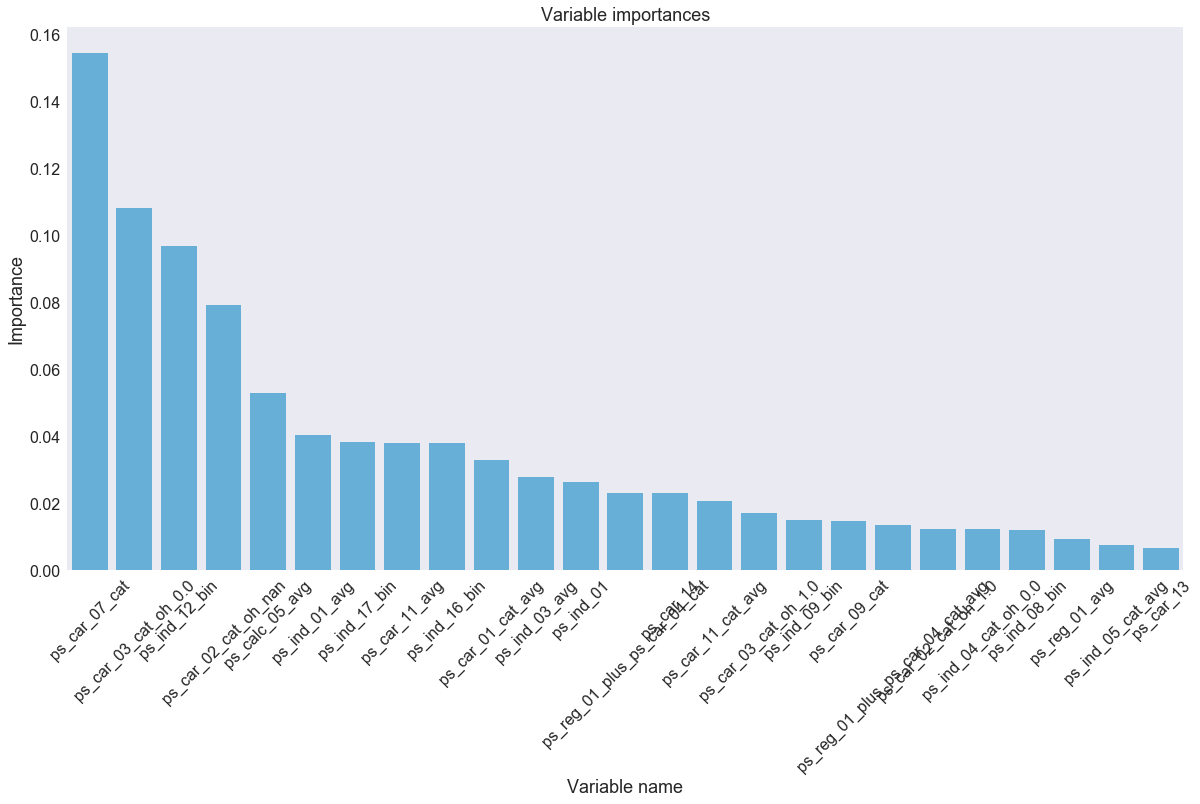

In [512]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
g=sns.barplot(data=feature_importance,x="feature",y="importance",ax=ax,color=default_color,)
for item in g.get_xticklabels():
    item.set_rotation(45)
ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances")

In [524]:
cross_val_model(te2_train[selected_features_te3b], y, rf_model)

Fit RandomForestClassifier fold 1


KeyboardInterrupt: 

In [523]:
cross_val_model(te2_train[selected_features_te3b], y, xgb_model)

Fit XGBClassifier fold 1
    cross_score: 0.64306 (0.28613)
    [       150 secs elapsed]: cross_score: 0.64306 (0.28613)
Fit XGBClassifier fold 2
    cross_score: 0.64722 (0.29444)
    [       323 secs elapsed]: cross_score: 0.64722 (0.29444)
Fit XGBClassifier fold 3
    cross_score: 0.64888 (0.29777)
    [       480 secs elapsed]: cross_score: 0.64888 (0.29777)
cross_score_mean: 0.64639 (0.29278)


In [515]:
cross_val_model(te2_train[selected_features_te3b], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.66771 (0.33543)
    [        27 secs elapsed]: cross_score: 0.66771 (0.33543)
Fit LGBMClassifier fold 2
    cross_score: 0.67081 (0.34162)
    [        54 secs elapsed]: cross_score: 0.67081 (0.34162)
Fit LGBMClassifier fold 3
    cross_score: 0.67036 (0.34072)
    [        83 secs elapsed]: cross_score: 0.67036 (0.34072)
cross_score_mean: 0.66963 (0.33926)


In [585]:
selected_features_te3d = selected_features_te3b.copy()
for c in ['ps_reg_03_avg', 'ps_car_04_cat', 'ps_calc_05', 'ps_calc_09', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_05_cat'
         , 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_reg_01_plus_ps_car_02_cat', 'ps_reg_01_plus_ps_car_04_cat'
          , 'ps_ind_04_cat', 'ps_reg_02', 'ps_ind_03_avg', 'ps_car_11_avg', 'ps_car_15_avg', 'ps_car_11_cat']:
    selected_features_te3d.remove(c)

In [586]:
sorted([x[:len('ps_ind_04')] + ' - ' + x for x in selected_features_te3d])

['ps_calc_0 - ps_calc_05_avg',
 'ps_calc_0 - ps_calc_09_avg',
 'ps_car_01 - ps_car_01_cat_avg',
 'ps_car_02 - ps_car_02_cat_oh_0.0',
 'ps_car_02 - ps_car_02_cat_oh_1.0',
 'ps_car_02 - ps_car_02_cat_oh_nan',
 'ps_car_03 - ps_car_03_cat_oh_0.0',
 'ps_car_03 - ps_car_03_cat_oh_1.0',
 'ps_car_03 - ps_car_03_cat_oh_nan',
 'ps_car_04 - ps_car_04_cat_avg',
 'ps_car_05 - ps_car_05_cat_oh_0.0',
 'ps_car_05 - ps_car_05_cat_oh_1.0',
 'ps_car_05 - ps_car_05_cat_oh_nan',
 'ps_car_06 - ps_car_06_cat_avg',
 'ps_car_07 - ps_car_07_cat_oh_0.0',
 'ps_car_07 - ps_car_07_cat_oh_1.0',
 'ps_car_07 - ps_car_07_cat_oh_nan',
 'ps_car_08 - ps_car_08_cat',
 'ps_car_09 - ps_car_09_cat_avg',
 'ps_car_11 - ps_car_11',
 'ps_car_11 - ps_car_11_cat_avg',
 'ps_car_12 - ps_car_12',
 'ps_car_13 - ps_car_13',
 'ps_car_14 - ps_car_14',
 'ps_car_15 - ps_car_15',
 'ps_ind_01 - ps_ind_01',
 'ps_ind_01 - ps_ind_01_avg',
 'ps_ind_02 - ps_ind_02_cat',
 'ps_ind_02 - ps_ind_02_cat_avg',
 'ps_ind_03 - ps_ind_03',
 'ps_ind_04 - ps_i

In [587]:
cross_val_model(te2_train[selected_features_te3d], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.63613 (0.27226)
    [        28 secs elapsed]: cross_score: 0.63613 (0.27226)
Fit LGBMClassifier fold 2
    cross_score: 0.63455 (0.26911)
    [        50 secs elapsed]: cross_score: 0.63455 (0.26911)
Fit LGBMClassifier fold 3
    cross_score: 0.63831 (0.27661)
    [        73 secs elapsed]: cross_score: 0.63831 (0.27661)
cross_score_mean: 0.63633 (0.27266)


In [572]:
cross_val_model(te2_train[selected_features_te3c], y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.66510 (0.33021)
    [        20 secs elapsed]: cross_score: 0.66510 (0.33021)
Fit LGBMClassifier fold 2
    cross_score: 0.67052 (0.34105)
    [        40 secs elapsed]: cross_score: 0.67052 (0.34105)
Fit LGBMClassifier fold 3
    cross_score: 0.67010 (0.34020)
    [        64 secs elapsed]: cross_score: 0.67010 (0.34020)
cross_score_mean: 0.66858 (0.33715)


In [580]:
feature_importance = get_feature_importance_df(lgb_model.feature_importances_, features)
feature_importance

,feature,importance
0,ps_car_07_cat_oh_1.0,303
1,ps_ind_14,294
2,ps_car_05_cat_oh_1.0,261
3,ps_car_02_cat_oh_1.0,207
4,ps_reg_02,194
5,ps_calc_05_avg,172
6,ps_ind_05_cat_avg,150
7,ps_ind_12_bin,147
8,ps_car_08_cat,144
9,ps_car_03_cat_oh_0.0,141


In [581]:
lgb_model.fit(te2_train[selected_features_te3d], y)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=3, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.8, learning_rate=0.05,
        max_bin=255, max_depth=5, metric='binary_logloss',
        min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=20, objective='binary',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        sub_feature=0.8, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [582]:
y_pred = lgb_model.predict_proba(te2_test[selected_features_te3d])[:,1]

In [583]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('lgb_feateng03d.csv', index=False)

In [517]:
xgb_model.fit(te2_train[selected_features_te3b], y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=4,
       min_child_weight=100, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=6e-05, reg_lambda=7e-06,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [518]:
y_pred_xgb = xgb_model.predict_proba(te2_test[selected_features_te3b])[:,1]

In [519]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred_xgb
sub.to_csv('xgb_feateng03b.csv', index=False)